# P5 - Vehicle Detection and Tracking

In this project I created a vehicle tracking pipeline using supervised learning algorithms on image related features from a vehicle dataset.

In [106]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from utils.imread_rgb import imread_rgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 1. Classification

The first step in solving the problem of identifying and tracking vehicles is to implement a binary classification algorithm which is capable of distinguishing between vehicles and non-vehicles. To implement this algorithm, i extracted gradient, color and spatial features from images and evaluated various standard classification algorithms from the sklearn toolkit.

In [107]:
vehicle_files = glob.glob('vehicles/*/*.png')
non_vehicle_files = glob.glob('non-vehicles/*/*.png')
vehicle_images = [imread_rgb(im) for im in vehicle_files]
nonvehicle_images = [imread_rgb(im) for im in non_vehicle_files]

In [108]:
images = np.vstack((vehicle_images, nonvehicle_images))
del vehicle_images
del nonvehicle_images

In [109]:
labels = np.hstack((np.ones(len(vehicle_files)), np.zeros(len(non_vehicle_files))))

In [110]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels)

### 1.1. Feature Selection
There are multiple techniques to extract features from a given image. I decided to evaluate a handful of techniques by changing color space and various parameters of the feature extraction algorithms and comparing how well they train a linear SVM.

To compare the quality of the features I evaluated the f1_score metric which is a weighted average or the precision, recall scores of the classification algorithm.

#### 1.1.1 HOG features
The Histogram of Gradient (HOG) is a feature descriptor found in traditional computer vision techniques. The technique counts occurences of gradient orientations in a localized portion of a given image, the main idea of the algorithm is that shapes of objects in an image can be described by these gradient orientations are thus considered useful. I used the ```skimage.feature.hog``` function to extract hog features from the images and determine which parameters seem to work best.


In [111]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from feature_extractors.hog_extractor import extract_hog_features

In [112]:
color_spaces = ['RGB','HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
print('color_space \t orient \t pix_per_cell \t channel \t f1_score')
for color_space in color_spaces:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))
    for im in X_test:
        X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    clf = LinearSVC()
    clf.fit(X_train_features, y_train)
    y_preds = clf.predict(X_test_features)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} \t{} : \t{}'.format(color_space, orient,  pix_per_cell, cell_per_block, channel, f1))
                    

color_space 	 orient 	 pix_per_cell 	 channel 	 f1_score
RGB 	9 	8 	2 	ALL : 	0.9714807209673739
HSV 	9 	8 	2 	ALL : 	0.9876993166287015
LUV 	9 	8 	2 	ALL : 	0.9824721147279764
HLS 	9 	8 	2 	ALL : 	0.9883906214432052
YUV 	9 	8 	2 	ALL : 	0.9851834966947801
YCrCb 	9 	8 	2 	ALL : 	0.9856524709633342


In [12]:
color_space = 'RGB'
orients = [5,7,9,13,16]
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
print('color_space \t orient \t pix_per_cell \t channel \t f1_score')
for orient in orients:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))
    for im in X_test:
        X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    clf = LinearSVC()
    clf.fit(X_train_features, y_train)
    y_preds = clf.predict(X_test_features)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} \t{} : \t{}'.format(color_space, orient,  pix_per_cell, cell_per_block, channel, f1))
                    

color_space 	 orient 	 pix_per_cell 	 channel 	 f1_score
RGB 	5 	8 	2 	ALL : 	0.9611872146118721
RGB 	7 	8 	2 	ALL : 	0.9699747879899153
RGB 	9 	8 	2 	ALL : 	0.9741596158243769
RGB 	13 	8 	2 	ALL : 	0.9727376861397481
RGB 	16 	8 	2 	ALL : 	0.9715726730857405


From the exploration above I find that the hog features in the YUV space should give a better performance.
I also find that the optimal number of orients is 9 in the RGB space, so i train a svm on YUV space with 9 orients to evaluate the results

In [16]:
color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
X_train_features = []
X_test_features = []
for im in X_train:
    X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel))
for im in X_test:
    X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel))

X_train_features = np.asarray(X_train_features).astype(np.float64)
X_test_feature = np.asarray(X_test_features).astype(np.float64)
clf = LinearSVC()
clf.fit(X_train_features, y_train)
y_preds = clf.predict(X_test_features)
f1 = f1_score(y_test, y_preds)
print(f1)

0.985870556062


#### 1.1.2 Color Features
I next explore features related to color, specifically color distribution of the images in various color spaces  and spatial binning of colors

In [3]:
from feature_extractors.bin_spatial import extract_color_features

In [9]:
color_spaces = ['RGB','HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
print('color_space \t spatial_size \t hist_bins \t hist_range \t f1_score')
for color_space in color_spaces:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range))
    for im in X_test:
        X_test_features.append(extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    X_scalar = StandardScaler().fit(np.vstack([X_train_features, X_test_features]))
    X_train_scaled = X_scalar.transform(X_train_features)
    X_test_scaled = X_scalar.transform(X_test_features)
    clf = LinearSVC()
    clf.fit(X_train_scaled, y_train)
    y_preds = clf.predict(X_test_scaled)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} : \t{}'.format(color_space, spatial_size,  hist_bins, hist_range, f1))

color_space 	 spatial_size 	 hist_bins 	 hist_range 	 f1_score
RGB 	(32, 32) 	32 	(0, 256) : 	0.9492070788324523
HSV 	(32, 32) 	32 	(0, 256) : 	0.9482163406214039
LUV 	(32, 32) 	32 	(0, 256) : 	0.9394650398873768
HLS 	(32, 32) 	32 	(0, 256) : 	0.940797051370652
YUV 	(32, 32) 	32 	(0, 256) : 	0.950338074143157
YCrCb 	(32, 32) 	32 	(0, 256) : 	0.947294776119403


I find that the YUV colorspace seems to be training the SVM the best, thus i decide to use the YUV color features as well as the YUV colorspace HOG descriptors to train my classification model.

In [8]:
color_space = 'YUV'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
X_train_features = []
X_test_features = []
for im in X_train:
    hog_features = extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel)
    
    color_features = extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range)
    features = np.hstack(
        (np.asarray(hog_features).astype(np.float64), 
         np.asarray(color_features).astype(np.float64))
    )
    X_train_features.append(features)
for im in X_test:
    hog_features = extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel)
    
    color_features = extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range)
    features = np.hstack(
        (np.asarray(hog_features).astype(np.float64), 
         np.asarray(color_features).astype(np.float64))
    )
    X_test_features.append(features)

X_train_features = np.asarray(X_train_features).astype(np.float64)
X_test_feature = np.asarray(X_test_features).astype(np.float64)
X_scalar = StandardScaler().fit(np.vstack([X_train_features, X_test_features]))
X_train_scaled = X_scalar.transform(X_train_features)
X_test_scaled = X_scalar.transform(X_test_features)


In [9]:
clf = LinearSVC()
clf.fit(X_train_scaled, y_train)
y_preds = clf.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print(f1)

0.992707383774


#### 1.1.3 Feature Scaling
When combining the HOG features and color features we find that their scales do not match, this would result int the classifier getting biased results to a specific type of feature. To remove this i scaled the feature vectors using the standard scalar in sklearn

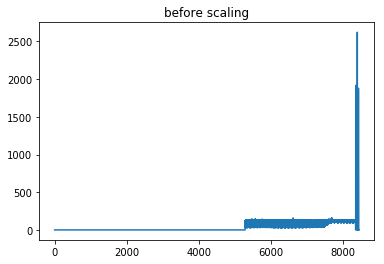

In [23]:
%matplotlib inline
plt.plot(X_train_features[0])
plt.title('before scaling')

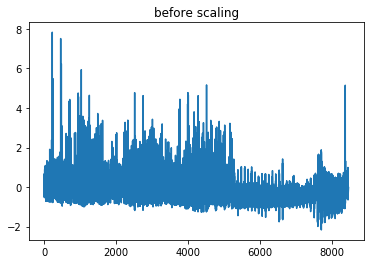

In [24]:
%matplotlib inline
plt.plot(X_train_scaled[0])
plt.title('before scaling')

### 1.2. Selecting a Classifier
Having determined features which can be used to train classification models. I decided to compare different classification models to determine which model to use for the final classifier.
the chosen models for comparison are :

1. LinearSVC
2. RandomForest
3. Bagging Ensemble of SVMs 

In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [39]:
clfA = LinearSVC()
clfB = RandomForestClassifier()
clfC = GaussianNB()

clfA.fit(X_train_scaled, y_train)
y_preds = clfA.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfA f1: {}'.format(f1))


clfB.fit(X_train_scaled, y_train)
y_preds = clfB.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfB f1: {}'.format(f1))


clfC.fit(X_train_scaled, y_train)
y_preds = clfC.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfC f1: {}'.format(f1))

clfA f1: 0.9918256130790191
clfB f1: 0.9859931113662457
clfC f1: 0.9649570666047806


After comparing a handful of classifiers , I found that the LinearSVC is given the best f1 score, thus I continued to use it as my classification algorithm.

## 1.3 Classifier Finetuning  

After determining the useful features and deciding on a specific classifier to use. I decided to use grid search to determine optimal parameters for the Linear SVM classifier for this specific problem.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

parameters = {
    'C': [0.1, 1, 10, 100]
}

f1_scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(LinearSVC(), 
                        param_grid=parameters,
                        scoring=f1_scorer)

grid_obj.fit(X_train_scaled, y_train)

clf = grid_obj.best_estimator_
y_preds = clf.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print(f1)

0.991825613079


after varying the C parameter for the linear SVC i found that it doesnt really affect the f1_score by much. I decided to use the Linear SVC with a C parameter of 1 as the final classifier for this project.

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'final_clf.pkl') 
joblib.dump(X_scalar, 'feature_scaler.pkl')
feature_params = {
    'color_space' : 'YUV',
    'spatial_size' : (32,32),
    'hist_bins' : 32,
    'hist_range' : (0, 256),
    'orient' : 9,
    'pix_per_cell' : 8,
    'cell_per_block' : 2,
    'channel' : 'ALL'
}
joblib.dump(feature_params, 'feature_params.pkl')

## 2. Sliding Window and Object Localization 

After training a classifier to detect vehicles in images , we can now slide the classifier accross an image of different size at various scales to determine whether an object is present in the image or not. 

### 2.1 Basic Sliding Window
I initially just divide an image into a bunch of fixed size smaller windows and run the classifier to determine whether the patch will be correctly classified or not.

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
image = imread_rgb('test_images/test1.jpg')

(-0.5, 1279.5, 719.5, -0.5)

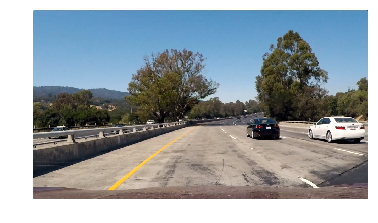

In [8]:
%matplotlib inline 
plt.imshow(image)
plt.axis('off')

In [39]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

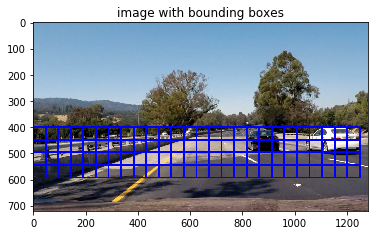

In [46]:
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.title('image with bounding boxes')

In [41]:
from sklearn.externals import joblib
clf = joblib.load('final_clf.pkl')
scaler = joblib.load('feature_scaler.pkl')
feature_params = joblib.load('feature_params.pkl')

In [42]:
from feature_extractors.hog_extractor import extract_hog_features
from feature_extractors.bin_spatial import extract_color_features

def find_cars_basic(image, 
                    clf=clf, 
                    scaler=scaler, 
                    feature_params=feature_params, 
                    x_start_stop=[None,None],
                    y_start_stop=[400,600],
                    xy_window=(96,96),
                    xy_overlap=(0.5, 0.5)):
    
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)
    hot_windows = []
    for window in windows:
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        hog_features = extract_hog_features(test_img, 
                                            cspace=feature_params['color_space'], 
                                            orient=feature_params['orient'], 
                                            pix_per_cell=feature_params['pix_per_cell'], 
                                            cell_per_block=feature_params['cell_per_block'], 
                                            hog_channel=feature_params['channel'])
        color_features = extract_color_features(test_img, 
                                                cspace=feature_params['color_space'],
                                                spatial_size=feature_params['spatial_size'], 
                                                hist_bins=feature_params['hist_bins'], 
                                                hist_range=feature_params['hist_range'])

        features = np.hstack(
            (np.asarray(hog_features).astype(np.float64), 
             np.asarray(color_features).astype(np.float64))
        )
        features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(features)
        if prediction == 1:
                hot_windows.append(window)
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6) 
    return window_img, hot_windows

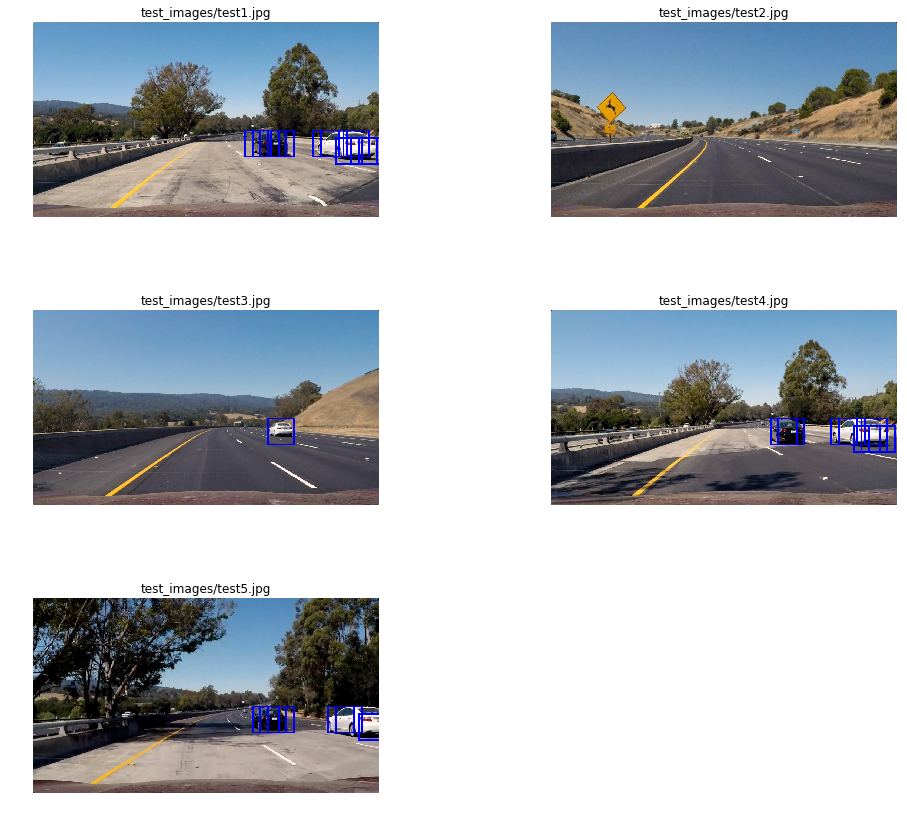

In [56]:
import matplotlib.gridspec as gridspec

test_images = glob.glob('test_images/*.jpg')
figure = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(3, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
    wspace=0.5)

for i,test_im in enumerate(test_images[:-1]):
    im = imread_rgb(test_im)
    ax = plt.subplot(gs[i])
    show_im, hot = find_cars_basic(im, xy_window=(96,96), xy_overlap=(0.7, 0.7), x_start_stop=[None,None])
    plt.imshow(show_im)
    ax.set_title(test_im)
    ax.axis('off')

In [49]:
image = imread_rgb('test_images/test4.jpg')

In [93]:
%time im  = find_cars_basic(image, xy_window=(80,80), xy_overlap=(0.8, 0.7), x_start_stop=[None,None])
%time im  = find_cars_basic(image, xy_window=(96,96), xy_overlap=(0.6, 0.6), x_start_stop=[None,None])
%time im  = find_cars_basic(image, xy_window=(112,112), xy_overlap=(0.6, 0.6), x_start_stop=[None,None])
%time im  = find_cars_basic(image, xy_window=(128,128), xy_overlap=(0.7, 0.7), x_start_stop=[None,None])


CPU times: user 2.63 s, sys: 16 ms, total: 2.64 s
Wall time: 2.79 s
CPU times: user 729 ms, sys: 9.24 ms, total: 738 ms
Wall time: 863 ms
CPU times: user 412 ms, sys: 6.59 ms, total: 418 ms
Wall time: 435 ms
CPU times: user 560 ms, sys: 5.56 ms, total: 566 ms
Wall time: 573 ms


While this basic method seems to work pretty well at correctly identifying the cars in all the test images, there are some pitfalls:

1. hog features are being extracted multiple times which is an expensive operation

2. the bounding boxes do not tightly bound the car and multiple boxes are drawn over a single detection
3. sometimes the classifier detects vehicles in places where there are none

## 2.3 False Positive Correction


To improve the quality of the detection, we want to have high confidence in the detections made by the algorithm and tighter boxes around the individual objects. To do this i followed the following steps:
1. generate bounding boxes using classifiers at multiple scales, i chose to run at 80x80, 96x96, 112x112 and 128x128 windows with different overlap parameters. the window sizes and parameters were chosen by experimentation to optimize speed and quality of the detection, i found that instead of increasing overlap if we rerun with changes in  the size of the windows the algorithm performs faster and gives similar results.
2. create heatmaps from all the positive detected areas, to do this i instatiate a matrix of the shape of the image with 0 and add 1 for every area under the detected bounding boxes.

3. threshhold the heatmaps so that only areas of high confidence are kept and false positives are discarded. since the algorithm runs on gradient and color features, we find that running at a different scale prevents the algorithm generally from detecting a false positive region again.

4. cluster the hotspots of the heatmap and estimate new bounding boxes for the clustered areas. This was done using the ```scipy.ndimage.measurements.label``` function.

In [94]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


    




In [100]:
from scipy.ndimage.measurements import label
def find_car_heatmap(image, thresh=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    _im, hot_80 = find_cars_basic(image, xy_window=(80,80), xy_overlap=(0.8, 0.6), x_start_stop=[None,None])
    _im, hot_96 = find_cars_basic(image, xy_window=(96,96), xy_overlap=(0.7, 0.6), x_start_stop=[None,None])
    _im, hot_112 = find_cars_basic(image, xy_window=(112,112), xy_overlap=(0.7, 0.6), x_start_stop=[None,None])
    _im, hot_128 = find_cars_basic(image, xy_window=(128,128), xy_overlap=(0.7, 0.7), x_start_stop=[None,None])
    
    hot_windows  = []
    hot_windows.extend(hot_80)
    hot_windows.extend(hot_96)
    hot_windows.extend(hot_112)
    hot_windows.extend(hot_128)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap, draw_img

#### heatmap images

CPU times: user 21.8 s, sys: 151 ms, total: 21.9 s
Wall time: 22.1 s


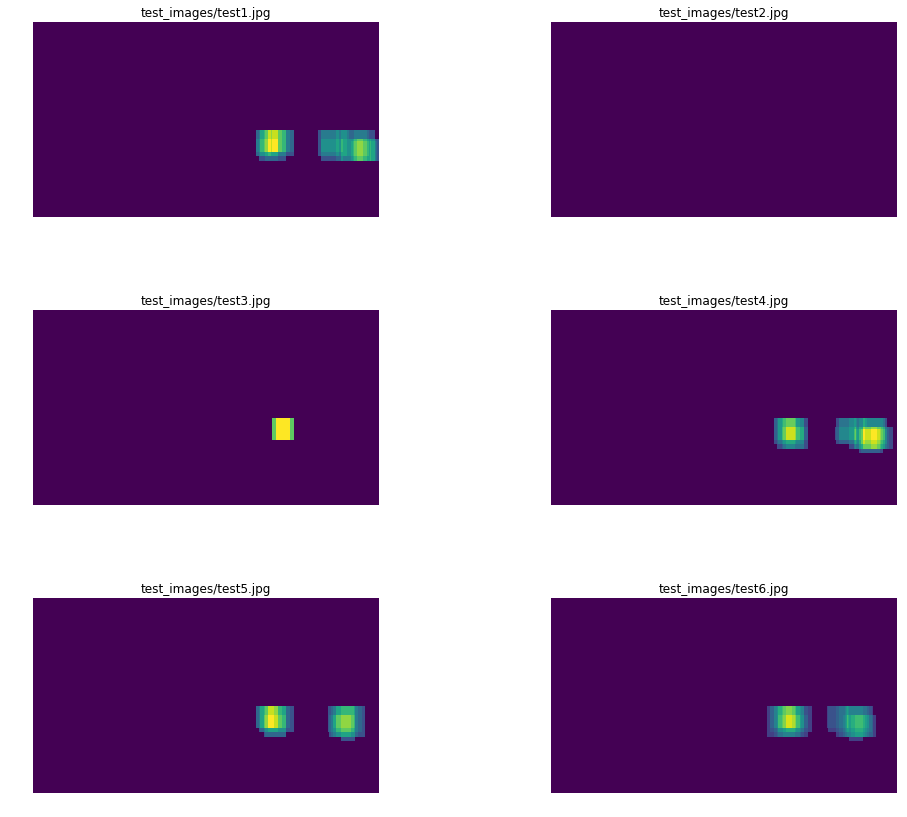

In [101]:
%%time
import matplotlib.gridspec as gridspec

test_images = glob.glob('test_images/*.jpg')
figure = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(3, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
    wspace=0.5)

for i,test_im in enumerate(test_images):
    im = imread_rgb(test_im)
    ax = plt.subplot(gs[i])
    heatmap, final = find_car_heatmap(im)
    plt.imshow(heatmap)
    ax.set_title(test_im)
    ax.axis('off')

#### new bounding boxes

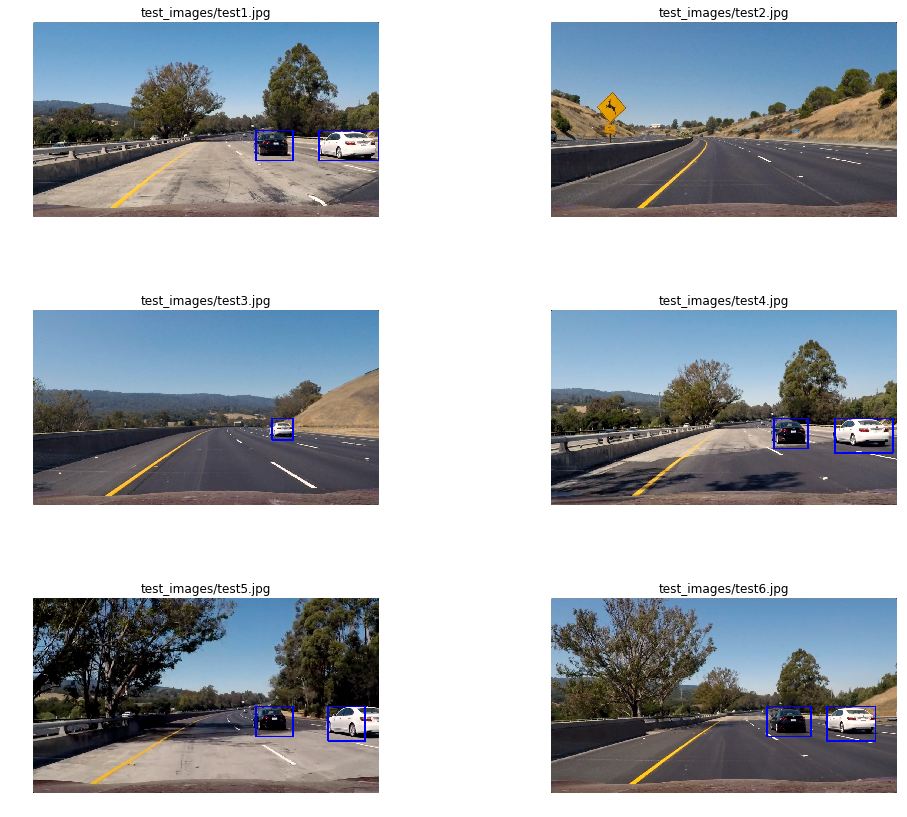

In [102]:
import matplotlib.gridspec as gridspec

test_images = glob.glob('test_images/*.jpg')
figure = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(3, 2, top=1., bottom=0., right=0.8, left=0., hspace=0.,
    wspace=0.5)

for i,test_im in enumerate(test_images):
    im = imread_rgb(test_im)
    ax = plt.subplot(gs[i])
    heatmap, final = find_car_heatmap(im)
    plt.imshow(final)
    ax.set_title(test_im)
    ax.axis('off')

## 3. Video Pipeline
Satisfied with the results of the improved detection algorithm, i simply used moviepy to process each frame of the video and generate bounding boxes for the images. The final video of the project can be found [here](https://www.youtube.com/watch?v=w3i5vyJTySk)

In [103]:
def final_pipeline(image):
    return find_car_heatmap(image)[1]

In [104]:
from moviepy.editor import VideoFileClip

In [105]:
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!
project_clip.write_videofile('final_output.mp4', audio=False)

[MoviePy] >>>> Building video final_output.mp4
[MoviePy] Writing video final_output.mp4


100%|█████████▉| 1260/1261 [1:19:42<00:03,  3.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_output.mp4 



## Reflection 

The current implementation of the algorithm does a decent job at detecting vehicles in individual images and consistently detects vehicles accross the video this is mainly because the classifier and features were chosen in a way which gets the best f1_score on the training dataset.

However I did find certain limitations which could be addressed in future iterations of the project.

1. When processing the video we find that the algorithm sometimes shows breif flickers of detections of a few false positives as well as cars on the oncoming lane on the side, but does not do so consisently. An approach to remove these flickers could be to keep track of the detected clusters accross the last few frames and only draw the boxes when we know the cluster is consistent. this would make the algorithm more robust in the video setting.

2. The Bounding boxes seem to be a bit wobbly and changing accross multiple frames even though the car isnt really changing size that much, this is mainly due to the way I detect the cars in each frame using discrete sliding windows. An improvement of the algorithm might be to swap out the classifier for a segmentation algorithm which labels pixels and then we draw bounding boxes over the labelled pixels.

3. In the initial iteration of the project I had trained a simple classifier with just RGB hog features, while this classifier gave good detections it also made many false positives; by choosing a feature space and classification algorithm which gives very high accuracy, the number of false positives decreases quite dramatically. It is probably worthwhile to explore a convolution neural net approch for classifiction which is known to outperform the traditional ML algorithms at the task of image classification.

4. Currently the pipeline is quite slow, it processes the video at 0.5 fps which is completely unacceptable to put into a real car, this is mainly because the feature extraction accross all the sliding windows are done repeatedly. An improvement to the speed of the detection could be to subsample the feature maps after precomputing accross the entire image ( i had explored this initially but the false positive rates were coming very high), another approach would be to reduce the number of sliding windows by running a big scale window accross the entire image and only running smaller scales at recognized patches ( this would require the classifier to be scale invarient ).